In [131]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
#from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

df = pd.read_csv('datasets/training_data.csv',encoding='cp1252')
teste = pd.read_csv('datasets/test_data.csv',encoding='cp1252')

ordem = {'None':0, 'Low':1, 'Medium':2, 'High':3, 'Very_High':4}

del df['AVERAGE_PRECIPITATION']
del teste['AVERAGE_PRECIPITATION']
df['AVERAGE_CLOUDINESS'].fillna(method='bfill',inplace=True)
df['AVERAGE_RAIN'].fillna(method='bfill',inplace=True)
df.dropna(inplace=True)

#Preparação para colocar nos modelos
X = df.drop(['AVERAGE_SPEED_DIFF'],axis=1)
y = df['AVERAGE_SPEED_DIFF'].to_frame()
Y = df['AVERAGE_SPEED_DIFF'].map(ordem)#.to_frame()
X_test = teste

city = LabelEncoder()
date = LabelEncoder()
luminosity = LabelEncoder()
cloudiness = LabelEncoder()
rain = LabelEncoder()
city_t = LabelEncoder()
date_t = LabelEncoder()
luminosity_t = LabelEncoder()
cloudiness_t = LabelEncoder()
rain_t = LabelEncoder()

X['city_name_n'] = city.fit_transform(X['city_name'])
X['record_date_n'] = date.fit_transform(X['record_date'])
X['LUMINOSITY_n'] = luminosity.fit_transform(X['LUMINOSITY'])
X['AVERAGE_CLOUDINESS_n'] = cloudiness.fit_transform(X['AVERAGE_CLOUDINESS'])
X['AVERAGE_RAIN_n'] = rain.fit_transform(X['AVERAGE_RAIN'])

X_test['city_name_n'] = city_t.fit_transform(X_test['city_name'])
X_test['record_date_n'] = date_t.fit_transform(X_test['record_date'])
X_test['LUMINOSITY_n'] = luminosity_t.fit_transform(X_test['LUMINOSITY'])
X_test['AVERAGE_CLOUDINESS_n'] = cloudiness_t.fit_transform(X_test['AVERAGE_CLOUDINESS'])
X_test['AVERAGE_RAIN_n'] = rain_t.fit_transform(X_test['AVERAGE_RAIN'])

X_n = X.drop(['city_name', 'record_date', 'LUMINOSITY', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'],axis=1)
X_test_n = X_test.drop(['city_name', 'record_date', 'LUMINOSITY', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'],axis=1)

def round_pred(pred,predictions):
    for n in pred:
        n = int(round(n))
        if n == 0:
            predictions.append('None')
        elif n == 1:
            predictions.append('Low')
        elif n == 2:
            predictions.append('Medium')
        elif n == 3:
            predictions.append('High')
        else:
            predictions.append('Very_High')


In [3]:
df.columns

Index(['city_name', 'record_date', 'AVERAGE_SPEED_DIFF',
       'AVERAGE_FREE_FLOW_SPEED', 'AVERAGE_TIME_DIFF',
       'AVERAGE_FREE_FLOW_TIME', 'LUMINOSITY', 'AVERAGE_TEMPERATURE',
       'AVERAGE_ATMOSP_PRESSURE', 'AVERAGE_HUMIDITY', 'AVERAGE_WIND_SPEED',
       'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'],
      dtype='object')

In [146]:
df.head()

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN
0,Porto,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,céu claro,chuva fraca
1,Porto,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,céu claro,chuva fraca
2,Porto,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,céu claro,chuva fraca
3,Porto,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,céu claro,chuva fraca
4,Porto,2019-06-06 12:00:00,Medium,41.6,50.4,77.0,LIGHT,15.0,1008.0,82.0,10.0,nuvens dispersas,chuva fraca


In [52]:
df.describe()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000
mean,40.661010,25.637111,81.143952,16.193482,1017.388139,80.084190,3.058573
std,4.119023,33.510507,8.294401,5.163492,5.751061,18.238863,2.138421
min,30.500000,0.000000,46.400000,0.000000,985.000000,14.000000,0.000000
25%,37.600000,2.275000,75.400000,13.000000,1015.000000,69.750000,1.000000
50%,40.700000,12.200000,82.400000,16.000000,1017.000000,83.000000,3.000000
75%,43.500000,36.200000,87.400000,19.000000,1021.000000,93.000000,4.000000
max,55.900000,296.500000,112.000000,35.000000,1033.000000,100.000000,14.000000


In [68]:
df.isna().any()

city_name                  False
record_date                False
AVERAGE_SPEED_DIFF         False
AVERAGE_FREE_FLOW_SPEED    False
AVERAGE_TIME_DIFF          False
AVERAGE_FREE_FLOW_TIME     False
LUMINOSITY                 False
AVERAGE_TEMPERATURE        False
AVERAGE_ATMOSP_PRESSURE    False
AVERAGE_HUMIDITY           False
AVERAGE_WIND_SPEED         False
AVERAGE_CLOUDINESS          True
AVERAGE_RAIN                True
dtype: bool

In [147]:
df[df.duplicated(['record_date'], keep=False)]

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_RAIN


In [23]:
df.groupby(by=['LUMINOSITY']).agg(pd.Series.mode)

,city_name,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_PRECIPITATION,AVERAGE_RAIN
LUMINOSITY,,,,,,,,,,,,
DARK,Porto,None,41.9,0.0,87.0,17.0,1017.0,100.0,1.0,céu claro,0.0,chuva fraca
LIGHT,Porto,Medium,40.0,0.0,87.4,20.0,1016.0,100.0,3.0,céu claro,0.0,chuva fraca
LOW_LIGHT,Porto,None,40.8,0.0,85.7,18.0,1016.0,100.0,2.0,céu claro,0.0,chuva fraca


<AxesSubplot:xlabel='AVERAGE_WIND_SPEED', ylabel='AVERAGE_SPEED_DIFF'>

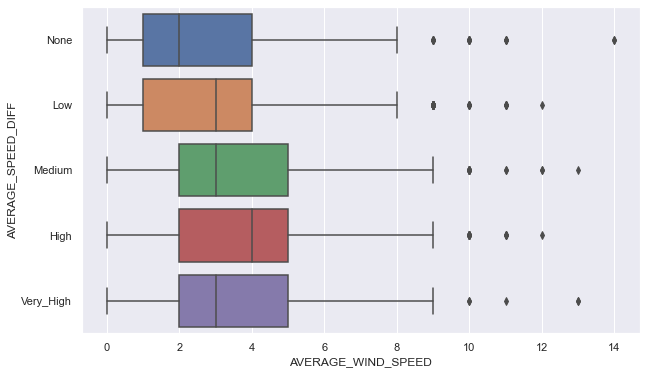

In [106]:
sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x=df['AVERAGE_WIND_SPEED'],y=df['AVERAGE_SPEED_DIFF'],order=ordem)

<AxesSubplot:xlabel='AVERAGE_RAIN', ylabel='count'>

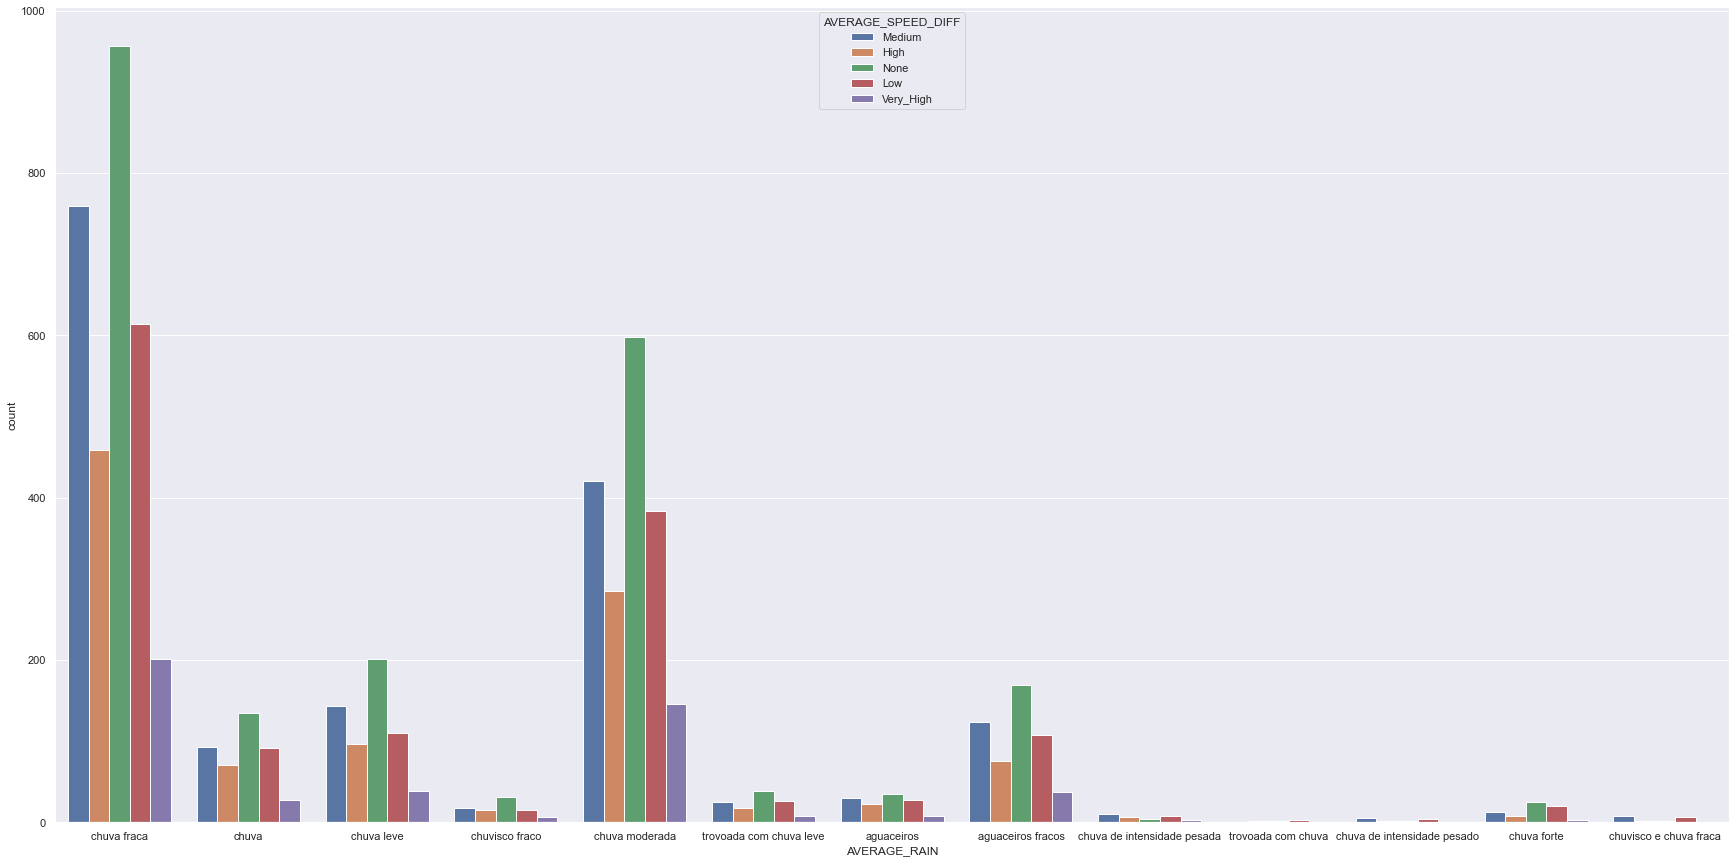

In [95]:
sns.set(rc={'figure.figsize':(30,15)})
sns.countplot(x=df['AVERAGE_RAIN'],hue=df['AVERAGE_SPEED_DIFF'])

<AxesSubplot:xlabel='AVERAGE_SPEED_DIFF', ylabel='Count'>

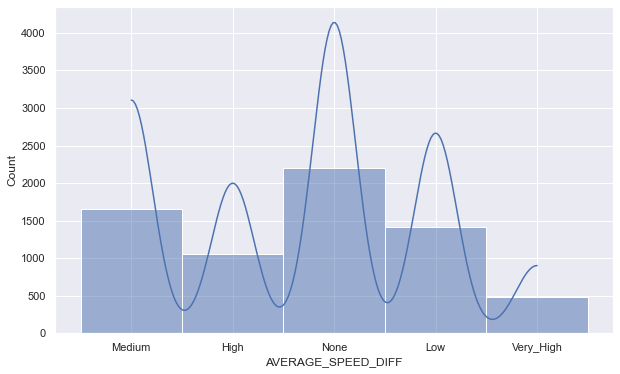

In [110]:
sns.histplot(df['AVERAGE_SPEED_DIFF'],kde=True)

In [27]:
#Decision Tree Classifier

#X_train,X_test,y_train,y_test = train_test_split(X_n,y, test_size=0.2, random_state=2)

dtc = DecisionTreeClassifier(random_state=2)
dtc.fit(X_n,y)

predictions = dtc.predict(X_test_n)
predictions

#accuracy_score(y_test, predictions)

# cm = confusion_matrix(y_test, predictions)
# plt.figure()
# plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
# plt.title("Decision Tree Model - Confusion Matrix")
# plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
# plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
# plt.show()

array(['None', 'Low', 'None', ..., 'None', 'Very_High', 'Medium'],
      dtype=object)

In [105]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_n,Y)

pred = lr.predict(X_test_n)
predictions = []
round_pred(pred,predictions)
        
predictions

['None',
 'Low',
 'None',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Medium',
 'None',
 'Low',
 'Medium',
 'Medium',
 'Medium',
 'High',
 'None',
 'Medium',
 'Low',
 'Low',
 'None',
 'None',
 'Low',
 'None',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'None',
 'Very_High',
 'Low',
 'Low',
 'Very_High',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'None',
 'Low',
 'None',
 'Medium',
 'Very_High',
 'Medium',
 'Low',
 'Low',
 'None',
 'Low',
 'Low',
 'Low',
 'Medium',
 'High',
 'Medium',
 'None',
 'Medium',
 'High',
 'High',
 'Very_High',
 'None',
 'None',
 'Low',
 'Low',
 'Low',
 'Very_High',
 'None',
 'Very_High',
 'Low',
 'Medium',
 'Very_High',
 'None',
 'Low',
 'Low',
 'Low',
 'Very_High',
 'Medium',
 'Low',
 'None',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Very_High',
 'None',
 'None',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Medium',
 'Medium',
 'None',
 'None',
 'High',
 'Medium',
 'None',
 'High',
 'None',
 'None',
 'High',
 'Medium',
 'Low',
 'None',
 'None',
 'Medi

In [5]:
#Logistic Regression
logr = LogisticRegression(max_iter=10000)
logr.fit(X_n,Y)

pred = logr.predict(X_test_n)
predictions = []
round_pred(pred,predictions)

#predictions

LogisticRegression(max_iter=10000)


In [141]:
#SVC
#print(X_n.info())
model = LinearSVC(dual=False)
model.fit(X_n,np.ravel(y))

predictions = model.predict(X_test_n)
for x in predictions:
    print(x)

None
Low
None
Medium
None
Medium
Low
Medium
None
Medium
None
None
Medium
Medium
Medium
High
None
High
Low
None
None
None
Low
None
Medium
High
Medium
None
None
High
None
Low
Very_High
Medium
None
None
Low
Medium
Medium
None
None
None
Medium
Very_High
High
Low
Medium
None
Medium
None
Low
Medium
High
Medium
None
Very_High
Very_High
High
Very_High
None
None
Very_High
None
Medium
High
None
High
Low
High
High
None
Medium
Medium
Medium
High
Very_High
None
None
Medium
Very_High
Low
Medium
Very_High
None
None
Medium
None
Medium
None
Very_High
Medium
None
None
Medium
Medium
None
High
None
None
Very_High
Medium
Medium
None
None
Medium
Medium
Very_High
Medium
Medium
None
Low
None
High
High
None
Low
Medium
None
None
Very_High
None
None
High
Low
Medium
High
Low
Very_High
Medium
None
Medium
None
Medium
High
Very_High
Medium
Medium
Medium
Very_High
Medium
None
Medium
High
High
Low
Medium
High
High
Medium
None
Medium
None
None
High
Very_High
Medium
Medium
High
Medium
Low
Medium
High
None
Medium
Medium


In [126]:
#K-Means
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_n,Y)

predictions = kmeans.fit_predict(X_test_n)
predictions


array([0, 0, 2, ..., 2, 0, 1])

In [142]:
submission = open("submissions/submission6.csv", "w", newline='')
writer = csv.writer(submission)
writer.writerow(['RowId', 'Speed_Diff'])
rowId = list(range(0, 1500))
for i in range(1500):
    writer.writerow([rowId[i]+1, predictions[i]])

submission.close()
    